Goal <br>
The goal of this project is to profile people in the above dataset based on available demographic attributes, and tell a story to non-technical audience on your findings. <br>
Example questions to guide your exploration include: <br>
1)	What are the key factors contributing to high vs. low income? <br>
2)	Are there any significant gaps in these Census attributes by gender or race? <br>
3)	Who are most likely to be successful investors? <br>
You are welcome to explore beyond these questions, if you discover anything else that might interest you along the way.

# 1. Questions: <br>
1) Key factors contributing to high vs low income? <br>
2) What is the profile of people having high income vs low income? <br>
3) Is the gap between income by gender or race significant? <br>
4) How can we predict if a person has high / low income? <br>
5) How can we find the people who would be successful inverstors? <br>

# 2. Importing data 

In [270]:
#Importing libraries
import pandas as pd
import io
import requests
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import statsmodels.api as sm

In [271]:
url="https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
content =requests.get(url).content
columns = ["age", "workingclass", "fnlwgt", "education", "education-num", "marital-status", "occupation" , "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"] 
adult_df=pd.read_csv(io.StringIO(content.decode('utf-8')), header = None)

In [272]:
adult_df.columns = columns
adult_df.head()

,age,workingclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# 3. Exploratory data analysis

## 1) Dataset information from UCI

UCI has given information about the data and features. We need to understand it thoroughly before we do any analysis.

The data is extracted from 1994 Census database using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0)) <br>
Following are the attributes and their types: <br>
&emsp;1) **age:** continuous <br>
&emsp;2) **workclass:** categorical  <br>
&emsp;3) **fnlwgt:** continuous, represents the number of units the record represents in the population. Unclear of it's usage <br>
&emsp;4) **education:** categorical <br>
&emsp;5) **education-num:** continuous<br>
&emsp;6) **marital-status:** categorical <br>
&emsp;7) **occupation:** categorical <br>
&emsp;8) **relationship:** categorical. Values - Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. Unclear of it's usage as a person might have multiple relationships <br>
&emsp;9) **race:** categorical<br>
&emsp;10) **sex:** categorical<br>
&emsp;11) **capital-gain:** continuous <br>
&emsp;12) **capital-loss:** continuous <br>
&emsp;13) **hours-per-week:** continuous, number of work the person has worked for in a week<br>
&emsp;14) **native-country:** categorical <br>
&emsp;15) **income:** categorical, class (not attribute) <=50K and >50K

##  2) High level overview

In [273]:
#Attribute statistics 
adult_df.shape

(32561, 15)

We have 32,561 records and 14 attributes. Last column is the income class

In [274]:
#removing end blank spaces
df_obj = adult_df.select_dtypes(['object'])
adult_df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

In [275]:
#Check for missing values in all the columns
adult_df.isin(["?"]).sum()

age                  0
workingclass      1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

Since missing values are not many we can drop those rows which have missing values

In [276]:
adult_df = adult_df.loc[adult_df["workingclass"] !="?"]
adult_df = adult_df.loc[adult_df["occupation"] !="?"]
adult_df = adult_df.loc[adult_df["native-country"] !="?"]

In [277]:
print(str(adult_df.shape))
print("Lost rows = "+str(round(1 - (adult_df.shape[0]/32561),4)*100)+"%")

(30162, 15)
Lost rows = 7.37%


Now we have 30162 rows

In [278]:
#Describe each continuous variable
adult_df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,1.897938e+05,10.121312,1092.007858,88.372489,40.931238
std,13.134665,1.056530e+05,2.549995,7406.346497,404.298370,11.979984
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176272e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.784250e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.376285e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


**Observations:** <br>
1) Age of all the individauls is **>17** <br>
2) age, education-num and hours-per-week **seem approx. normal distributions**. We can further check the distributions to confirm <br>
3) More than 75% of the data in capital-gain and capital-loss column is 0 as we see with **3rd Quartile (75%) = 0** <br>
4) **fnlwgt can be dropped** as we're unclear of it's usage 

In [279]:
# dropping fnlwgt
adult_df.drop("fnlwgt", axis = 1, inplace = True)

In [280]:
#Describe each categorical variable
adult_df.describe(include = ["O"])

,workingclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,30162,30162,30162,30162,30162,30162,30162,30162,30162
unique,7,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22286,9840,14065,4038,12463,25933,20380,27504,22654


**Observation:** <br> 
Most (~70% +) of the data consists of people of **workingclass = Private, Race = White, Native country = US, incomce <=50K**

##  3) Analysing each variable and encoding

### a) Continuous variables

**Age, education-num and hours-per-week**

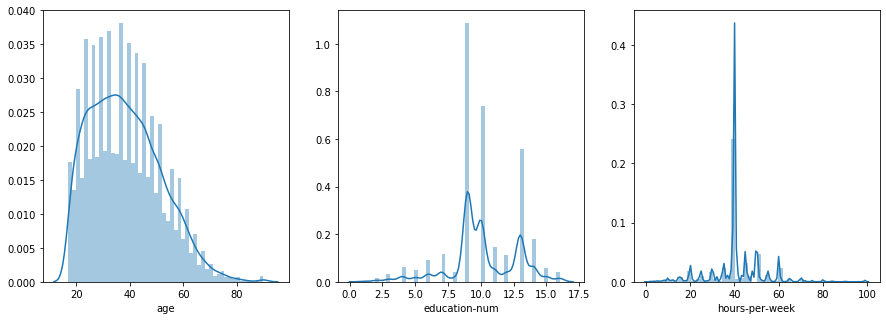

In [281]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
sns.distplot(adult_df["age"], ax = ax[0])
sns.distplot(adult_df["education-num"], ax = ax[1])
sns.distplot(adult_df["hours-per-week"], ax = ax[2])

**Age is right skewed distribution** since we have the dataset of adults only <br>
**Education-num is not continuous** and has integer values only, we can further check this <br>
Hours-per-week has a **huge spike at 40** which is normal 

**Capital-loss and capital-gain**

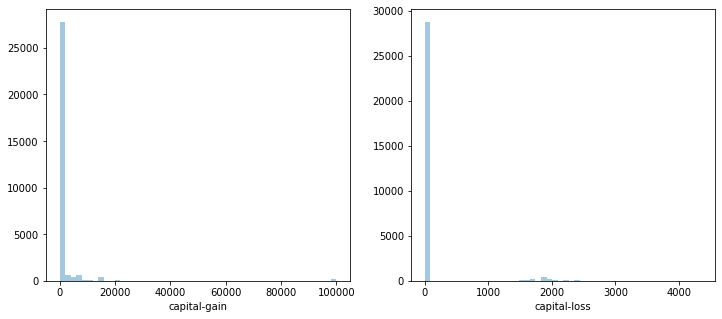

In [282]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.distplot(adult_df["capital-gain"], ax = ax[0], kde = False)
sns.distplot(adult_df["capital-loss"], ax = ax[1], kde = False)

Most values in capital-gain and capital-loss are 0

In [283]:
print("Percentage of 0 values in capital-gain = "+str(round(np.mean(adult_df["capital-gain"]==0),2)*100)+"%")

Percentage of 0 values in capital-gain = 92.0%


In [284]:
print("Percentage of 0 values in capital-gain = "+str(round(np.mean(adult_df["capital-loss"]==0),2)*100)+"%")

Percentage of 0 values in capital-gain = 95.0%


In [285]:
adult_df.drop(["capital-gain", "capital-loss"], axis = 1, inplace = True)

### b) Categorical variables

**Education**

Education-num and education are expected to be highly correlated. We check this using a contingency table. 

In [286]:
cont_table = pd.crosstab(adult_df["education"],adult_df["education-num"], margins = False)
cont_table

education-num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
education,,,,,,,,,,,,,,,,
10th,0,0,0,0,0,820,0,0,0,0,0,0,0,0,0,0
11th,0,0,0,0,0,0,1048,0,0,0,0,0,0,0,0,0
12th,0,0,0,0,0,0,0,377,0,0,0,0,0,0,0,0
1st-4th,0,151,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5th-6th,0,0,288,0,0,0,0,0,0,0,0,0,0,0,0,0
7th-8th,0,0,0,557,0,0,0,0,0,0,0,0,0,0,0,0
9th,0,0,0,0,455,0,0,0,0,0,0,0,0,0,0,0
Assoc-acdm,0,0,0,0,0,0,0,0,0,0,0,1008,0,0,0,0
Assoc-voc,0,0,0,0,0,0,0,0,0,0,1307,0,0,0,0,0


We can therefore, **drop education and use only enducation-num** in our analysis

In [287]:
adult_df.drop("education", axis = 1, inplace = True)

**Workingclass**

In [288]:
adult_df["workingclass"].value_counts()

Private             22286
Self-emp-not-inc     2499
Local-gov            2067
State-gov            1279
Self-emp-inc         1074
Federal-gov           943
Without-pay            14
Name: workingclass, dtype: int64

We can group occupation types into fewer categories are meaningful categories, though we might lose some information  <Br>

In [289]:
##Encoding different types of govt jobs to a single value
adult_df.loc[((adult_df["workingclass"] == "Federal-gov")| (adult_df["workingclass"] == "Local-gov")  |(adult_df["workingclass"] == "State-gov")), "workingclass"] = "Govt"
adult_df.loc[((adult_df["workingclass"] == "Self-emp-inc")| (adult_df["workingclass"] == "Self-emp-not-inc")), "workingclass"] = "Self-emp"
adult_df.loc[((adult_df["workingclass"] == "Without-pay")| (adult_df["workingclass"] == "Never-worked")), "workingclass"]  = "No-work-inc"

**Race**

In [290]:
adult_df["race"].value_counts()

White                 25933
Black                  2817
Asian-Pac-Islander      895
Amer-Indian-Eskimo      286
Other                   231
Name: race, dtype: int64

We hardly have any data for the last two categories, we can encode them into 1

In [291]:
adult_df.loc[(adult_df["race"] == "Amer-Indian-Eskimo"), "race"] = "Other"

**Marital-status**

In [292]:
adult_df["marital-status"].value_counts()

Married-civ-spouse       14065
Never-married             9726
Divorced                  4214
Separated                  939
Widowed                    827
Married-spouse-absent      370
Married-AF-spouse           21
Name: marital-status, dtype: int64

We can encode these into 3 categories - Married, Not-married (seperated, divorced and widowed) and Never-Married

In [293]:
adult_df["marital-status"] = adult_df["marital-status"].str.strip()
adult_df.loc[((adult_df["marital-status"] == "Married-civ-spouse") | (adult_df["marital-status"] == "Married-spouse-absent") | (adult_df["marital-status"] == "Married-AF-spouse")) , "marital-status"] = "Married"
adult_df.loc[((adult_df["marital-status"] == "Widowed") | (adult_df["marital-status"] == "Divorced") | (adult_df["marital-status"] == "Separated")) , "marital-status"] = "Not-Married"

**Occupation**

In [294]:
adult_df["occupation"].value_counts()

Prof-specialty       4038
Craft-repair         4030
Exec-managerial      3992
Adm-clerical         3721
Sales                3584
Other-service        3212
Machine-op-inspct    1966
Transport-moving     1572
Handlers-cleaners    1350
Farming-fishing       989
Tech-support          912
Protective-serv       644
Priv-house-serv       143
Armed-Forces            9
Name: occupation, dtype: int64

 Each occupation is unique. Some occupations have very counts and do not add much value to the data. We encode them by creating "Other" category 

In [295]:
adult_df.loc[((adult_df["occupation"] == "Other-service") | (adult_df["occupation"] == "Armed-Forces") | (adult_df["occupation"] == "Priv-house-serv") | (adult_df["occupation"] == "Protective-serv")),"occupation"] = "Other"

**Relationship**

Since we already have marital-status, **relationship is redundant** as husband, wife values which are majority will always be married. Therefore, we drop it

In [296]:
adult_df.drop("relationship",axis = 1,  inplace = True)

**Native-country**

In [297]:
cntry_counts = adult_df["native-country"].value_counts()
print(len(cntry_counts))
print(cntry_counts[0:2]/np.sum(cntry_counts))

41
United-States    0.911876
Mexico           0.020224
Name: native-country, dtype: float64


US and Mexico make up 93% of the total native-countries while other countries 39 countries have very less counts. We group them into other category 

In [298]:
adult_df.loc[((adult_df["native-country"] != "United-States") & (adult_df["native-country"] != "Mexico")),"native-country"] = "Other"

### c) Class - Distribution

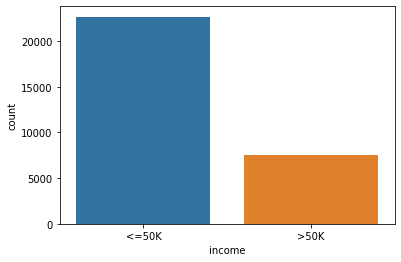

In [299]:
sns.countplot(adult_df["income"])

We have 75% of population below 50K income and 25% above 50K

## 4) Dummy encoding of categorical features

In [300]:
adult_df_new = pd.get_dummies(adult_df)

In [301]:
adult_df_new.columns

Index(['age', 'education-num', 'hours-per-week', 'workingclass_Govt',
       'workingclass_No-work-inc', 'workingclass_Private',
       'workingclass_Self-emp', 'marital-status_Married',
       'marital-status_Never-married', 'marital-status_Not-Married',
       'occupation_Adm-clerical', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_Other', 'occupation_Prof-specialty', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'race_White',
       'sex_Female', 'sex_Male', 'native-country_Mexico',
       'native-country_Other', 'native-country_United-States', 'income_<=50K',
       'income_>50K'],
      dtype='object')

In [302]:
adult_df_new.drop("workingclass_No-work-inc", axis = 1, inplace = True)
adult_df_new.drop("marital-status_Not-Married", axis = 1, inplace = True)
adult_df_new.drop("occupation_Other", axis = 1, inplace = True)
adult_df_new.drop("race_Other", axis = 1, inplace = True)
adult_df_new.drop("sex_Female", axis = 1, inplace = True)
adult_df_new.drop("native-country_Other", axis = 1, inplace = True)
adult_df_new.drop("income_<=50K", axis = 1, inplace = True)

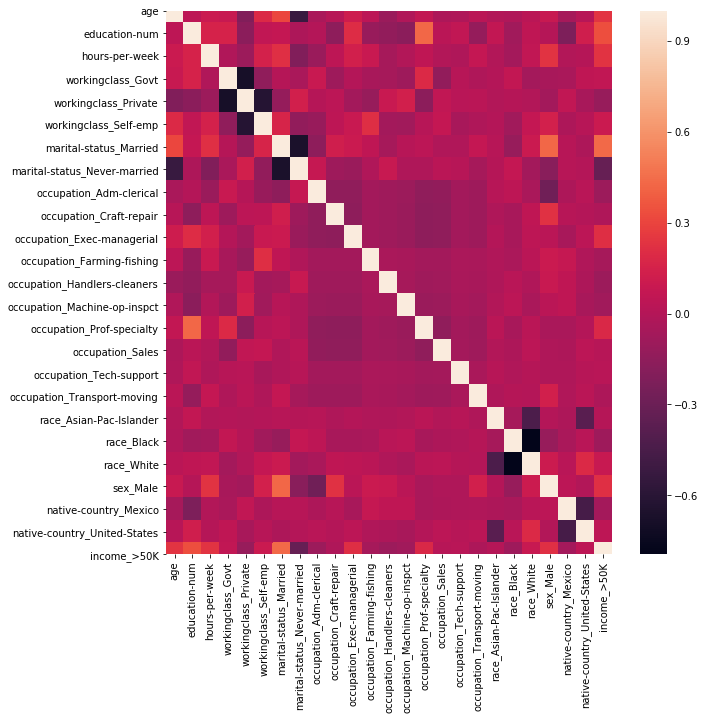

In [375]:
plt.figure(figsize = (10,10))
sns.heatmap(adult_df_new.corr())

**Observations:** <Br>
&emsp;    1) Age has a strong negative correlation with marital-status <br>
&emsp;    2) Native-country and race have a high correlation for specific values <br>
&emsp;    3) Surprisingly native-country also has correlation with education-num <br>
&emsp;    4) Many of the features have good correlation with the class income > 50k but we explore more in single factor analysis


# 4. Inferential Analysis

**Single factor analysis**: We try each feature and check whether it helps in determining income class. <br>
Logistic Regression is fit for simplicity and interpretability in terms of log of odds <br>
Note: These features may not be important in combination with others, single factor analysis however gives us an important factors individually for determining the classes

In [321]:
X = adult_df_new.loc[:, adult_df_new.columns != "income_>50K"]
X = X.astype(float)
y = adult_df_new["income_>50K"]
y =  y.astype(float)
X.insert(0,'constant',1)
summary = pd.DataFrame(columns =["variable","coeff size","odds-ratio", "direction","pvalue"])

In [322]:
X.columns

Index(['constant', 'age', 'education-num', 'hours-per-week',
       'workingclass_Govt', 'workingclass_Private', 'workingclass_Self-emp',
       'marital-status_Married', 'marital-status_Never-married',
       'occupation_Adm-clerical', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_Prof-specialty', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'race_Asian-Pac-Islander', 'race_Black', 'race_White', 'sex_Male',
       'native-country_Mexico', 'native-country_United-States'],
      dtype='object')

In [334]:
from sklearn.feature_selection import RFE

In [365]:
lr = LogisticRegression(solver = "lbfgs",penalty="none")

In [366]:
selector = RFE(lr, step=1)

In [367]:
selector.fit(adult_df_new.loc[:, adult_df_new.columns != "income_>50K"], y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='warn', n_jobs=None,
                                 penalty='none', random_state=None,
                                 solver='lbfgs', tol=0.0001, verbose=0,
                                 warm_start=False),
    n_features_to_select=None, step=1, verbose=0)

In [368]:
selector.ranking_

array([13,  3, 12,  1,  1,  1,  1,  1,  4,  5,  1,  1,  1, 11,  1,  1,  1,
        6, 10,  9,  7,  2,  1,  8])

In [370]:
adult_df_new.columns

Index(['age', 'education-num', 'hours-per-week', 'workingclass_Govt',
       'workingclass_Private', 'workingclass_Self-emp',
       'marital-status_Married', 'marital-status_Never-married',
       'occupation_Adm-clerical', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_Prof-specialty', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'race_Asian-Pac-Islander', 'race_Black', 'race_White', 'sex_Male',
       'native-country_Mexico', 'native-country_United-States', 'income_>50K'],
      dtype='object')

In [369]:
selector.support_

array([False, False, False,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True, False,  True,  True,  True, False,
       False, False, False, False,  True, False])

In [340]:
lr.fit(adult_df_new.loc[:, adult_df_new.columns != "income_>50K"], y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [341]:
lr.coef_

array([[ 0.0296173 ,  0.2995378 ,  0.03106801,  0.63274401,  0.62172992,
         0.42230818,  2.00455513, -0.47389341,  0.42032001,  0.35089306,
         1.19279101, -0.77564684, -0.41824006,  0.04806496,  0.90199472,
         0.6520003 ,  0.94159749,  0.18860875,  0.48096986,  0.44896236,
         0.57910336,  0.32541331, -0.4335486 ,  0.23394616]])

## 1) Age

In [323]:
var = "age"
lr_model = sm.Logit(y,X.loc[:,["constant", var]]).fit_regularized()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5323285305229516
            Iterations: 13
            Function evaluations: 17
            Gradient evaluations: 13


In [324]:
coeff_size = abs(lr_model.params[1])
odds_r = np.exp(lr_model.params[1])
direction = "positive" if lr_model.params[1] > 0 else "negative"
pval = lr_model.pvalues[1]

In [325]:
summary = summary.append({"variable":var,"coeff size": coeff_size, "odds-ratio":odds_r, "direction":direction, "pvalue":'%.3f'%pval}, ignore_index = True)

## 2) Education (num)

In [326]:
var = "education-num"
lr_model = sm.Logit(y,X.loc[:,["constant", var]]).fit_regularized()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.49912510525751813
            Iterations: 15
            Function evaluations: 17
            Gradient evaluations: 15


In [327]:
coeff_size = abs(lr_model.params[1])
odds_r = np.exp(lr_model.params[1])
direction = "positive" if lr_model.params[1] > 0 else "negative"
pval = lr_model.pvalues[1]

In [328]:
summary = summary.append({"variable":var,"coeff size": coeff_size, "odds-ratio":odds_r, "direction":direction, "pvalue":'%.3f'%pval}, ignore_index = True)

## 3) Hours-per-week

In [329]:
var = "hours-per-week"
lr_model = sm.Logit(y,X.loc[:,["constant", var]]).fit_regularized()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5343168715689085
            Iterations: 14
            Function evaluations: 18
            Gradient evaluations: 14


In [330]:
coeff_size = abs(lr_model.params[1])
odds_r = np.exp(lr_model.params[1])
direction = "positive" if lr_model.params[1] > 0 else "negative"
pval = lr_model.pvalues[1]

In [331]:
summary = summary.append({"variable":var,"coeff size": coeff_size, "odds-ratio":odds_r, "direction":direction, "pvalue":'%.3f'%pval}, ignore_index = True)

## 4) Working-class

In [332]:
var = ['workingclass_Govt', 'workingclass_Private', 'workingclass_Self-emp']
lr_model = sm.Logit(y,X.loc[:,["constant", var[0], var[1], var[2]]]).fit_regularized()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5538302267493812
            Iterations: 58
            Function evaluations: 59
            Gradient evaluations: 58


In [333]:
coeff_size = abs(lr_model.params[1])
odds_r = np.exp(lr_model.params[1])
direction = "positive" if lr_model.params[1] > 0 else "negative"
pval = lr_model.pvalues[1]
coeff_size2 = abs(lr_model.params[2])
odds_r2 = np.exp(lr_model.params[2])
direction2 = "positive" if lr_model.params[2] > 0 else "negative"
pval2 = lr_model.pvalues[2]
coeff_size3 = abs(lr_model.params[3])
odds_r3 = np.exp(lr_model.params[3])
direction3 = "positive" if lr_model.params[3] > 0 else "negative"
pval3 = lr_model.pvalues[3]

In [318]:
summary = summary.append({"variable":var[,"coeff size": coeff_size, "odds-ratio":odds_r, "direction":direction, "pvalue":'%.3f'%pval}, ignore_index = True)
summary = summary.append({"variable":var,"coeff size": coeff_size, "odds-ratio":odds_r, "direction":direction, "pvalue":'%.3f'%pval}, ignore_index = True)
summary = summary.append({"variable":var,"coeff size": coeff_size, "odds-ratio":odds_r, "direction":direction, "pvalue":'%.3f'%pval}, ignore_index = True)

In [320]:
summary

,variable,coeff size,odds-ratio,direction,pvalue
0,age,0.042345,1.043254e+00,positive,0.000
1,education-num,0.362038,1.436253e+00,positive,0.000
2,hours-per-week,0.046926,1.048044e+00,positive,0.000
3,"[workingclass_Govt, workingclass_Private, work...",14.611049,2.215633e+06,positive,0.980


## 1) Age

In [207]:
var = "age"
lr_model = sm.Logit(y,X.loc[:,["constant", var]]).fit()

Optimization terminated successfully.
         Current function value: 0.532329
         Iterations 6


In [210]:
coeff_size = abs(lr_model.params[1])
odds_r = np.exp(lr_model.params[1])
direction = "positive" if lr_model.params[1] > 0 else "negative"
pval = lr_model.pvalues[1]

In [211]:
summary = summary.append({"variable":var,"coeff size": coeff_size, "odds-ratio":odds_r, "direction":direction, "pvalue":'%.3f'%pval}, ignore_index = True)

## 1) Age

In [207]:
var = "age"
lr_model = sm.Logit(y,X.loc[:,["constant", var]]).fit()

Optimization terminated successfully.
         Current function value: 0.532329
         Iterations 6


In [210]:
coeff_size = abs(lr_model.params[1])
odds_r = np.exp(lr_model.params[1])
direction = "positive" if lr_model.params[1] > 0 else "negative"
pval = lr_model.pvalues[1]

In [211]:
summary = summary.append({"variable":var,"coeff size": coeff_size, "odds-ratio":odds_r, "direction":direction, "pvalue":'%.3f'%pval}, ignore_index = True)

## 1) Age

In [207]:
var = "age"
lr_model = sm.Logit(y,X.loc[:,["constant", var]]).fit()

Optimization terminated successfully.
         Current function value: 0.532329
         Iterations 6


In [210]:
coeff_size = abs(lr_model.params[1])
odds_r = np.exp(lr_model.params[1])
direction = "positive" if lr_model.params[1] > 0 else "negative"
pval = lr_model.pvalues[1]

In [211]:
summary = summary.append({"variable":var,"coeff size": coeff_size, "odds-ratio":odds_r, "direction":direction, "pvalue":'%.3f'%pval}, ignore_index = True)

## 1) Age

In [207]:
var = "age"
lr_model = sm.Logit(y,X.loc[:,["constant", var]]).fit()

Optimization terminated successfully.
         Current function value: 0.532329
         Iterations 6


In [210]:
coeff_size = abs(lr_model.params[1])
odds_r = np.exp(lr_model.params[1])
direction = "positive" if lr_model.params[1] > 0 else "negative"
pval = lr_model.pvalues[1]

In [211]:
summary = summary.append({"variable":var,"coeff size": coeff_size, "odds-ratio":odds_r, "direction":direction, "pvalue":'%.3f'%pval}, ignore_index = True)

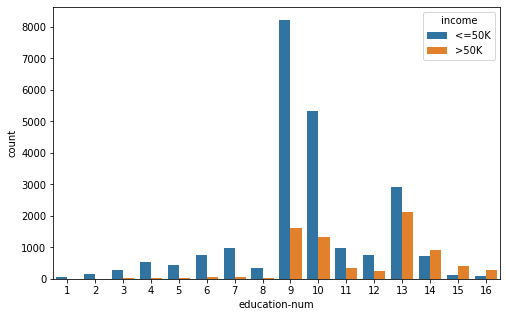

In [13]:
#Checking value wise counts of education-num
plt.figure(figsize = (8,5))
sns.countplot(adult_df["education-num"], hue = adult_df["income"])

As expected education-num only has integer values with spikes at 9,10 and 13 years of education <br>
Proportion of >50K income increases as compared to income <=50K as we more from left to right suggesting more the education in years more chances of earning > =50K <BR>


In [139]:
lr = LogisticRegression(C = 0.001 , solver = "lbfgs")

In [140]:
lr.fit(X.loc[:,["constant","age"]], y)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [141]:
lr.coef_

array([[-6.81637504e-07,  4.22987357e-02]])

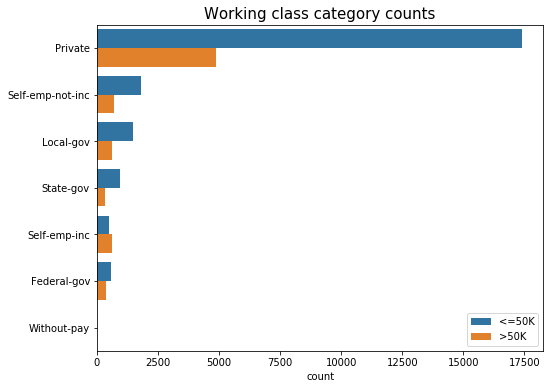

In [21]:
#Check distributions of categorical data 
plt.figure(figsize = (8,6))
s0 = sns.countplot(y= adult_df["workingclass"], order = adult_df["workingclass"].value_counts().index, hue = adult_df["income"])
s0.set_ylabel(None)
s0.set_title("Working class category counts",fontsize=15)
plt.legend(loc='lower right')

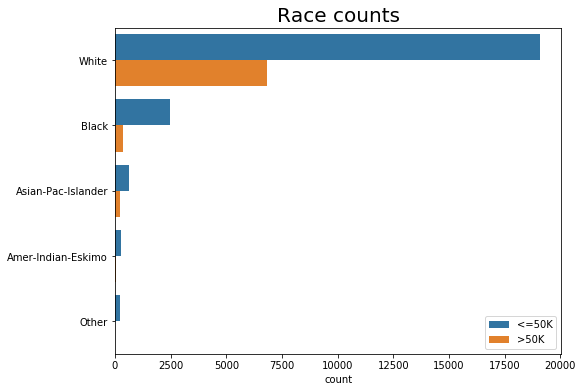

In [23]:
plt.figure(figsize = (8,6))
s1 = sns.countplot(y= adult_df["race"], order = adult_df["race"].value_counts().index, hue = adult_df["income"])
s1.set_ylabel(None)
s1.set_title("Race counts",fontsize=20)
plt.legend(loc='lower right')

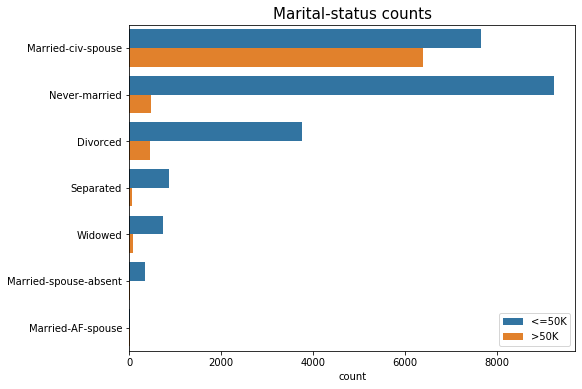

In [25]:
plt.figure(figsize = (8,6))
s2 = sns.countplot(y= adult_df["marital-status"], order = adult_df["marital-status"].value_counts().index, hue = adult_df["income"])
s2.set_ylabel(None)
s2.set_title("Marital-status counts",fontsize=15)
plt.legend(loc='lower right')

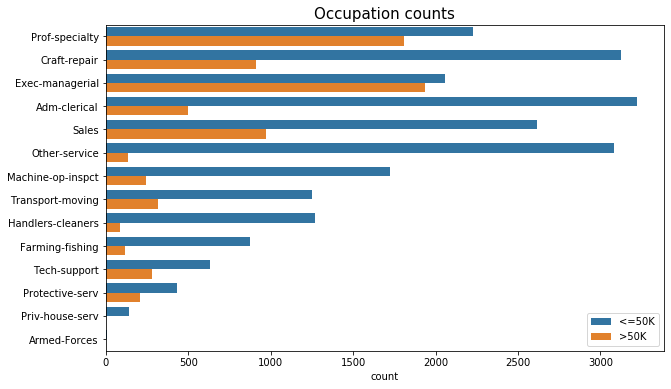

In [27]:
plt.figure(figsize = (10,6))
s3 = sns.countplot(y= adult_df["occupation"], order = adult_df["occupation"].value_counts().index, hue = adult_df["income"])
s3.set_ylabel(None)
s3.set_title("Occupation counts",fontsize=15)
plt.legend(loc='lower right')

**Exec-managerial** and **prof-speciality** have a higher proportion of >50K population as compated to other categories <br>  
Each occupation is unique and has a different distribution of class income. **Therefore, we do not group these occupation** 